In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape, Activation, Dropout
from keras.layers import Concatenate, Add
from keras.callbacks import ModelCheckpoint
os.chdir('code')
from utils import tf_haversine,get_clusters
from data import load_data
os.chdir('..')

Using TensorFlow backend.


In [2]:
data = load_data()

In [4]:
clusters = get_clusters(data.train_labels)

/home/benmosbahmohamed/KerasSolution/DeepLeraning_PredictionTaxi/code/utils.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  clusters = clusters.as_matrix()


In [5]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout,Input
from keras.layers.core import Reshape
from keras.layers import Concatenate,Add
from keras.callbacks import ModelCheckpoint
from utils import tf_haversine
from data import load_data
from utils import get_clusters
from keras.layers import concatenate



def start_new_session():
    """
    Starts a new Tensorflow session.
    """
    
    # Make sure the session only uses the GPU memory that it actually needs
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    
    session = tf.Session(config=config, graph=tf.get_default_graph())
    K.tensorflow_backend.set_session(session)


def first_last_k(coords):
    """
    Returns a list with the first k and last k GPS coordinates from the given trip.
    The returned list contains 4k values (latitudes and longitudes for 2k points).
    """
    k = 5
    partial = [coords[0] for i in range(2*k)]
    num_coords = len(coords)
    if num_coords < 2*k:
        partial[-num_coords:] = coords
    else:
        partial[:k] = coords[:k]
        partial[-k:] = coords[-k:]
    partial = np.row_stack(partial)
    return np.array(partial).flatten()


def process_features(df):
    """
    Process the features required by our model from the given dataframe.
    Return the features in a list so that they can be merged in our model's input layer.
    """
    # Fetch the first and last GPS coordinates
    coords = np.row_stack(df['POLYLINE'].apply(first_last_k))
    # Standardize latitudes (odd columns) and longitudes (even columns)
    latitudes = coords[:,::2]
    coords[:,::2] = scale(latitudes)
    longitudes = coords[:,1::2]
    coords[:,1::2] = scale(longitudes)
    
    return [
        df['QUARTER_HOUR'].as_matrix(),
        df['DAY_OF_WEEK'].as_matrix(),
        df['WEEK_OF_YEAR'].as_matrix(),
        df['ORIGIN_CALL_ENCODED'].as_matrix(),
        df['TAXI_ID_ENCODED'].as_matrix(),
        df['ORIGIN_STAND_ENCODED'].as_matrix(),
        coords,
    ]


def create_model(metadata, clusters):
    """
    Creates all the layers for our neural network model.
    """
      
    # Arbitrary dimension for all embeddings
    embedding_dim = 10

    # Quarter hour of the day embedding
    input_quarter_hour = Input(shape=(1,))
    embed_quarter_hour = Embedding(metadata['n_quarter_hours'], embedding_dim, input_length=1)(input_quarter_hour)
    embed_quarter_hour = Reshape((embedding_dim,))(embed_quarter_hour)

    # Day of the week embedding
    input_day_of_week = Input(shape=(1,))
    embed_day_of_week = Embedding(metadata['n_days_per_week'], embedding_dim, input_length=1)(input_day_of_week)
    embed_day_of_week = Reshape((embedding_dim,))(embed_day_of_week)

    # Week of the year embedding
    input_week_of_year = Input(shape=(1,))
    embed_week_of_year = Embedding(metadata['n_weeks_per_year'], embedding_dim, input_length=1)(input_week_of_year)
    embed_week_of_year = Reshape((embedding_dim,))(embed_week_of_year)

    # Client ID embedding
    input_client_ids = Input(shape=(1,))
    embed_client_ids = Embedding(metadata['n_client_ids'], embedding_dim, input_length=1)(input_client_ids)
    embed_client_ids = Reshape((embedding_dim,))(embed_client_ids)


    # Taxi ID embedding
    input_taxi_ids = Input(shape=(1,))
    embed_taxi_ids = Embedding(metadata['n_taxi_ids'], embedding_dim, input_length=1)(input_taxi_ids)
    embed_taxi_ids = Reshape((embedding_dim,))(embed_taxi_ids)


    # Taxi stand ID embedding
    input_stand_ids = Input(shape=(1,))
    embed_stand_ids = Embedding(metadata['n_stand_ids'], embedding_dim, input_length=1)(input_stand_ids)
    embed_stand_ids = Reshape((embedding_dim,))(embed_stand_ids)
    
    # GPS coordinates (5 first lat/long and 5 latest lat/long, therefore 20 values)

    coords_in = Input(shape=(20,))
    
    #model = Sequential()
    
    concatenated = concatenate([
                embed_quarter_hour,
                embed_day_of_week,
                embed_week_of_year,
                embed_client_ids,
                embed_taxi_ids,
                embed_stand_ids,
                coords_in
            ])
    
    out = Dense(500, activation='relu')(concatenated)
    
    out = Dense(len(clusters),activation='softmax',name='output_layer')(out)
    
    cast_clusters = K.cast_to_floatx(clusters)
    def destination(probabilities):
        return tf.matmul(probabilities, cast_clusters)
    
    out = Activation(destination)(out)
    
    model = Model([
                input_quarter_hour,
                input_day_of_week,
                input_week_of_year,
                input_client_ids,
                input_taxi_ids,
                input_stand_ids,
                coords_in
            ],out)
    
    

    # Compile the model
    optimizer = SGD(lr=0.01, momentum=0.9, clipvalue=1.)  # Use `clipvalue` to prevent exploding gradients
    model.compile(loss=tf_haversine, optimizer=optimizer)
    
    return model


def full_train(data,clusters,n_epochs=100, batch_size=200, save_prefix=None):
    """
    Runs the complete training process.
    """
    
    # Load initial data
    print("Loading data...")
    #data = load_data()
    data = data
    
    # Estimate the GPS clusters
    print("Estimating clusters...")
    #clusters = get_clusters(data.train_labels)
    clusters = clusters
    
    # Set up callbacks
    callbacks = []
    if save_prefix is not None:
        # Save the model's intermediary weights to disk after each epoch
        file_path="cache/%s-{epoch:03d}-{val_loss:.4f}.hdf5" % save_prefix
        callbacks.append(ModelCheckpoint(file_path, monitor='val_loss', mode='min', save_weights_only=True, verbose=1))

    # Create model
    print("Creating model...")
    start_new_session()
    model = create_model(data.metadata, clusters)
    
    # Run the training
    print("Start training...")
    history = model.fit(
        process_features(data.train), data.train_labels,
        nb_epoch=n_epochs, batch_size=batch_size,
        validation_data=(process_features(data.validation), data.validation_labels),
        callbacks=callbacks)

    if save_prefix is not None:
        # Save the training history to disk
        file_path = 'cache/%s-history.pickle' % save_prefix
        with open(file_path, 'wb') as handle:
            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return history

In [6]:
os.chdir('code')
from utils import tf_haversine,get_clusters
os.chdir('..')
history = full_train(data,clusters,save_prefix='TrainedOn10_2_5')

Loading data...
Estimating clusters...
Creating model...
Instructions for updating:
Colocations handled automatically by placer.
Start training...


/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Me

Instructions for updating:
Use tf.cast instead.


/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/benmosbahmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Me

Train on 1611521 samples, validate on 16444 samples
Epoch 1/100
1611521/1611521 [==============================] - 219s 136us/step - loss: 1.7873 - val_loss: 1.5955

Epoch 00001: saving model to cache/TrainedOn10_2_5-001-1.5955.hdf5
Epoch 2/100
1611521/1611521 [==============================] - 218s 135us/step - loss: 1.5740 - val_loss: 1.5600

Epoch 00002: saving model to cache/TrainedOn10_2_5-002-1.5600.hdf5
Epoch 3/100
1611521/1611521 [==============================] - 219s 136us/step - loss: 1.5488 - val_loss: 1.5515

Epoch 00003: saving model to cache/TrainedOn10_2_5-003-1.5515.hdf5
Epoch 4/100
1611521/1611521 [==============================] - 218s 135us/step - loss: 1.5344 - val_loss: 1.5281

Epoch 00004: saving model to cache/TrainedOn10_2_5-004-1.5281.hdf5
Epoch 5/100
1611521/1611521 [==============================] - 218s 135us/step - loss: 1.5238 - val_loss: 1.5215

Epoch 00005: saving model to cache/TrainedOn10_2_5-005-1.5215.hdf5
Epoch 6/100
1611521/1611521 [==============

KeyboardInterrupt: 

In [30]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

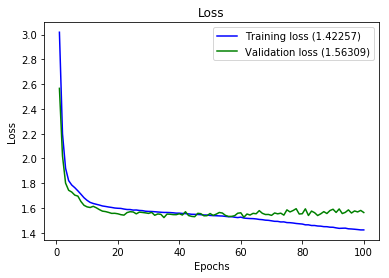

In [31]:
plot_history(history)

In [34]:
#Je regarde à quel point il est bon
#Je load les weights du modèle pas la peine de réentraîner hehe
start_new_session()
model = create_model(data.metadata, clusters)
#c'est là que je load les weights
model.load_weights('cache\TrainedOn10_2_5-100-1.5631.hdf5')


In [36]:
#Les prédictions sur l'ensemble de test de la compet (tout petit)
test_predictions = model.predict(process_features(data.test))

In [37]:
os.chdir('code')
from utils import np_haversine
os.chdir('..')
np_haversine(test_predictions, data.test_labels).mean()

1.4601464225973106

En s'entraînant que sur le dixième des données, on obtient une loss de 1.46 (km) sur le truc de test. C'est mieux que sur le blog... Soit j'ai mal copié un truc qui fait que ça marche mieux hahah, soit keras 2.x et meilleur que 1.x